In [2]:
import json
import os

import vk_api as vk
from dotenv import load_dotenv

load_dotenv()

VK_ACCESS_TOKEN = os.getenv("VK_ACCESS_TOKEN")

session = vk.VkApi(token=VK_ACCESS_TOKEN)

vk_api = session.get_api()

groups = vk_api.groups.get()
posts = {}

for group_id in groups["items"][:70]:
    posts[group_id] = vk_api.wall.get(owner_id=-group_id, count=7)

with open("posts.json", "w") as file:
    file.write(json.dumps(posts))


In [10]:
import json

text_messages_clean = []

with open(r"posts.json") as file:
    for line in file.readlines():
        wall = json.loads(line)

        parsed_response = json.JSONDecoder().decode(json.dumps(wall))
        nodes = []
        for key, value in parsed_response.items():
            nodes.append(value.get("items"))

        for node in nodes:
            for post in node:
                text = post.get("text")
                if text is not None:
                    text_messages_clean.append(text)



words = {}

for message in text_messages_clean:
    if message is None:
        print(message)
        continue
    for word in message.split():
        if word not in words:
            words[word] = 1
        else:
            words[word] += 1

words = dict(sorted(words.items(), key=lambda item: item[1], reverse=True))
print(words)

{'в': 390, 'и': 376, 'на': 213, 'с': 141, 'не': 139, '—': 118, 'что': 85, '-': 82, 'по': 80, 'В': 71, 'для': 55, 'это': 52, 'за': 52, 'из': 44, 'или': 44, 'а': 42, 'до': 41, 'к': 41, 'как': 40, '–': 32, 'у': 30, 'от': 29, 'его': 27, 'их': 27, 'я': 26, 'о': 26, 'он': 26, 'уже': 25, 'все': 23, 'года': 22, 'есть': 21, 'но': 21, 'только': 21, 'И': 21, 'которые': 20, 'без': 20, 'даже': 19, 'чтобы': 19, 'под': 19, 'вы': 18, 'просто': 18, 'А': 18, 'во': 18, 'мы': 17, 'С': 17, 'который': 17, '→': 17, 'может': 16, 'было': 16, 'Я': 16, 'этом': 16, 'видео': 16, 'можно': 16, 'вам': 15, 'если': 15, 'после': 15, 'По': 15, 'Как': 14, 'будет': 14, 'ноября': 14, 'вас': 14, '2': 14, '✓': 14, 'при': 13, 'У': 13, 'Если': 13, '2025': 13, '·': 13, 'России': 12, 'На': 12, 'между': 12, '6': 12, 'пока': 12, 'время': 12, 'так': 12, '//': 11, 'были': 11, 'где': 11, 'кто': 11, 'её': 11, 'области': 11, 'Это': 11, 'они': 11, 'почему': 11, 'был': 10, 'всегда': 10, 'будут': 10, 'всё': 10, 'больше': 10, 'Но': 10, 'рай

In [14]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
import matplotlib.pyplot as plt
import matplotlib as mpl
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [15]:
stemmer = SnowballStemmer("russian")

In [16]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
def token_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text)
              for word in nltk.word_tokenize(sent)]

    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)

    stems = [stemmer.stem(t) for t in filtered_tokens]

    return stems

def token_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text)
              for word in nltk.word_tokenize(sent)]

    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)

    return filtered_tokens

In [18]:
# Создаем списки для хранения всех стемм и токенов
totalvocab_stem = []
totalvocab_token = []

# Для каждого сообщения в массиве очищенных сообщений
for text_message in text_messages_clean:
    # Получаем стеммы для текущего сообщения
    allwords_stemmed = token_and_stem(text_message)
    totalvocab_stem.extend(allwords_stemmed)

    # Получаем токены для текущего сообщения
    allwords_tokenized = token_only(text_message)
    totalvocab_token.extend(allwords_tokenized)


In [19]:
print(f"Часть массива стемов: {totalvocab_stem[:25]}")
print(f"Часть массива токенов: {totalvocab_token[:25]}")

Часть массива стемов: ['пятниц', 'возвраща', 'в', 'эпох', 'когд', 'мир', 'был', 'на', 'пик', 'музыкальн', 'и', 'цифров', 'революц', 'а', 'жизн', 'каза', 'насыщен', 'и', 'полн', 'ярк', 'событ', 'а', 'социальн', 'сет', 'стал']
Часть массива токенов: ['пятница', 'возвращаемся', 'в', 'эпоху', 'когда', 'мир', 'был', 'на', 'пике', 'музыкальных', 'и', 'цифровых', 'революций', 'а', 'жизнь', 'казалась', 'насыщенной', 'и', 'полной', 'ярких', 'событий', 'а', 'социальные', 'сети', 'стали']


In [20]:
# Убедимся, что стоп-слова загружены
nltk.download('stopwords')

# Список русских стоп-слов
stopwords = nltk.corpus.stopwords.words('russian')
stopwords.extend([
    'что', 'это', 'так', 'вот', 'быть', 'как',
    'в', 'к', 'на', 'а', 'от', 'о', 'чут', 'даж', 'еще'
])

# Создание TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.75,          # исключение слов, встречающихся чаще 75% документов
    max_features=10000,   # максимальное число признаков
    min_df=0.01,          # исключение слов, встречающихся реже 1% документов
    stop_words=stopwords, # игнорирование стоп-слов
    use_idf=True,         # включение IDF (обратная частота)
    tokenizer=token_and_stem, # функция-обработчик токенизации и стемминга
    ngram_range=(1, 3)    # рассмотрение униграмм, биграмм и триграмм
)

# Применяем векторизацию к текстовым сообщениям
tfidf_matrix = tfidf_vectorizer.fit_transform(text_messages_clean)

print(f"Размерность матрицы весов TF-IDF:{tfidf_matrix.shape}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
G:\projects\university\social\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
G:\projects\university\social\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['бол', 'больш', 'будт', 'быт', 'вед', 'впроч', 'всег', 'всегд', 'друг', 'е', 'ег', 'ем', 'есл', 'ест', 'ещ', 'зач', 'зде', 'ил', 'иногд', 'когд', 'конечн', 'куд', 'лучш', 'межд', 'мен', 'мног', 'мо', 'можн', 'нег', 'нельз', 'нибуд', 'никогд', 'нич', 'опя', 'посл', 'пот', 'почт', 'разв', 'сво', 'себ', 'совс', 'теб', 'тепер', 'тог', 'тогд', 'тож', 'тольк', 'хорош', 'хот', 'чег', 'эт'] not in stop_words.
  warnings.warn(


Размерность матрицы весов TF-IDF:(486, 321)


In [21]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
num_clusters = 5


In [22]:
# Метод к-средних - KMeans
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
idx = km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
print(clusters)
print (km.labels_)
# MiniBatchKMeans
mbk = MiniBatchKMeans(init='random',
n_clusters=num_clusters)
mbk.fit_transform(tfidf_matrix)
mbk.fit(tfidf_matrix)
miniclusters = mbk.labels_.tolist()
print (mbk.labels_)


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [47]:
# DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(tfidf_matrix)
labels = db.labels_
labels.shape
print(labels)

[ 0 -1 -1 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1
 -1 -1  0  0 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0
  0 -1  0 -1  0 -1 -1 -1  0 -1 -1  0  0  0 -1  0  0 -1 -1 -1  0 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1
 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  0  0  0  0 -1  0  0 -1 -1 -1 -1 -1 -1 -1
  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0 -1 -1 -1  0 -1
 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1  0  0  0  0  0  0
  0  0 -1  0  0  0  0  0 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1
 -1 -1  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1  0  0  0  0 -1  0 -1 -1 -1
 -1 -1 -1 -1  0 -1  0  0  0  0  0  0  0  0 -1  0  0 -1  0 -1 -1  0  0  0
  0  0  0 -1 -1 -1  0 -1 -1 -1  0  0  0  0  0  0  0

In [48]:
# Аггломеративная класстеризация
# affinity можно выбрать любое или попробовать все поочереди: cosine, l1, l2, manhattan
agglo1 = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean')
answer = agglo1.fit_predict(tfidf_matrix.toarray())
answer.shape

(488,)

In [49]:
# K-средние
cluster_km = km.labels_.tolist()
# minikmeans
cluster_mbk = mbk.labels_.tolist()
# dbscan
cluster_dbscan = labels
# аггломеративная
cluster_agglom = answer.tolist()

# в out будет содержимое столбцов таблицы, columns - названия столбцов,
# index - столбец, по которому будет идти нумерация

# k-means
out = {'title': text_messages_clean, 'cluster': cluster_km}
frame_kmeans = pd.DataFrame(out, index=[cluster_km], columns=['title', 'cluster'])

# mini
out = {'title': text_messages_clean, 'cluster': cluster_mbk}
frame_minik = pd.DataFrame(out, index=[cluster_mbk], columns=['title', 'cluster'])

# dbscan
out = {'title': text_messages_clean, 'cluster': cluster_dbscan}
frame_dbscan = pd.DataFrame(out, index=[cluster_dbscan], columns=['title', 'cluster'])

# аггломеративная
out = {'title': text_messages_clean, 'cluster': cluster_agglom}
frame_agglom = pd.DataFrame(out, index=[cluster_agglom], columns=['title', 'cluster'])

# выведем суммарные значения по каждому из методов кластеризации
print(f"Число значений K-средние: {frame_kmeans['cluster'].value_counts()}")
print(f"Число значений MiniBatchKMeans: {frame_minik['cluster'].value_counts()}")
print(f"Число значений DBSCAN: {frame_dbscan['cluster'].value_counts()}")
print(f"Число значений аггломеративной конгламерации: {frame_agglom['cluster'].value_counts()}")


Число значений K-средние: cluster
1    477
4      7
3      2
2      1
0      1
Name: count, dtype: int64
Число значений MiniBatchKMeans: cluster
1    230
0    210
4     35
3     11
2      2
Name: count, dtype: int64
Число значений DBSCAN: cluster
-1    261
 0    227
Name: count, dtype: int64
Число значений аггломеративной конгламерации: cluster
1    262
0    205
2     10
3      6
4      5
Name: count, dtype: int64


In [50]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
cos_sim_frame = pd.DataFrame(dist)
cos_sim_frame

,0,1,2,3,4,5,6,7,8,9,...,478,479,480,481,482,483,484,485,486,487
0,1.0,1.0,1.000000e+00,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00
1,1.0,0.0,1.000000e+00,0.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00
2,1.0,1.0,-4.440892e-16,1.0,1.0,0.847543,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00
3,1.0,0.0,1.000000e+00,0.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00
4,1.0,1.0,1.000000e+00,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,1.0,1.0,1.000000e+00,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00
484,1.0,1.0,1.000000e+00,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00
485,1.0,1.0,1.000000e+00,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00
486,1.0,1.0,1.000000e+00,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00


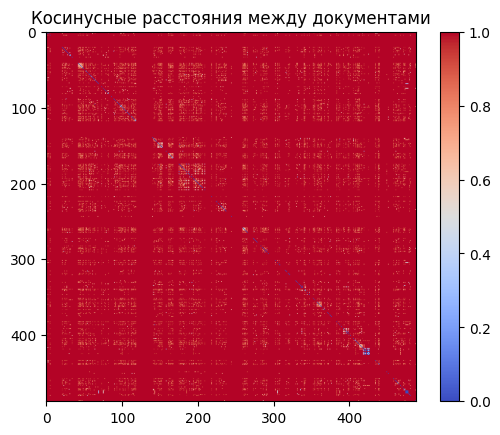

In [51]:
plt.imshow(dist, cmap='coolwarm')
# отображение "термометра"
plt.colorbar()
# название графика
plt.title('Косинусные расстояния между документами')
# показ графика
plt.show()

In [52]:
from sklearn.decomposition import IncrementalPCA

icpa = IncrementalPCA(n_components=2, batch_size=16)
icpa.fit(dist)

demo2 = icpa.transform(dist)

xs, ys = demo2[:, 0], demo2[:, 1]
print(ys)


[ 5.46227549e-02  4.09740542e-02  2.31781663e-02  4.09740542e-02
  5.46227549e-02 -3.68933591e-02  5.46227549e-02  5.46227549e-02
  5.46227549e-02  5.46227549e-02  5.46227549e-02  5.46227549e-02
  5.46227549e-02  5.46227549e-02  5.46227549e-02  5.46227549e-02
  5.46227549e-02  5.46227549e-02  5.46227549e-02  5.46227549e-02
  5.46227549e-02 -3.23323793e-02  5.74659121e-02 -4.05213793e-02
  2.57157822e-02 -2.50249689e-02  3.62173823e-02  1.16593830e-02
  6.69359042e-02  5.15960013e-02 -1.09606084e-01  6.70792335e-02
  6.56825266e-02  5.46227549e-02  4.24255010e-02  5.46227549e-02
  5.46227549e-02  5.46227549e-02  5.46227549e-02  5.46227549e-02
  5.46227549e-02  5.46227549e-02 -7.77787451e-02 -3.24132637e-02
 -4.61072273e-02 -6.24644305e-02  1.02478686e-02  1.62061945e-02
 -2.18297270e-02 -2.51974732e-02  5.46227549e-02  5.46227549e-02
 -4.29717356e-02 -4.47965046e-02  5.89394562e-03  5.46227549e-02
 -8.00668102e-02  1.08344066e-01 -1.75105460e-02  7.33635705e-02
  7.30571814e-02  2.52347

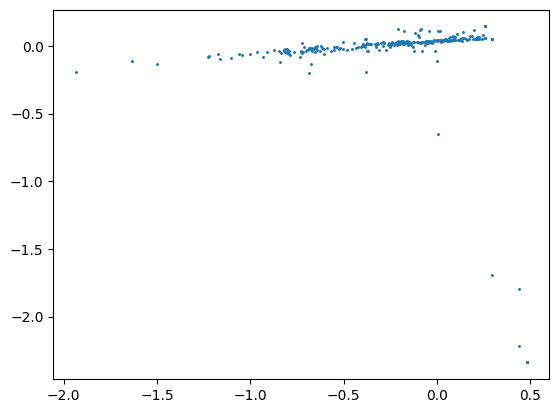

In [53]:
plt.scatter(xs, ys, marker='.', s=5)

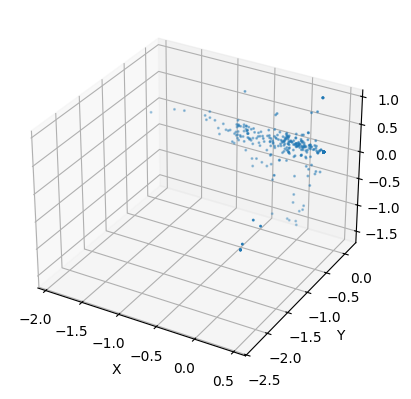

In [54]:
from sklearn.decomposition import IncrementalPCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Понижение размерности данных до 3-х компонент
icpa = IncrementalPCA(n_components=3, batch_size=16)
icpa.fit(dist)

# Преобразование данных
dist_3d = icpa.transform(dist)
xs, ys, zs = dist_3d[:, 0], dist_3d[:, 1], dist_3d[:, 2]

# Визуализация результатов в 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, marker='.', s=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()
